# Pump it Up Challenge Exploratory Data Analysis

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import category_encoders as ce

In [2]:
# custom helper function to get counts and percents by group
def count_pct(dataframe, column):
    # calculate grouped counts
    grp_count = (
        dataframe.groupby(column)
        .size()
        .reset_index(name = 'count')
        .sort_values(['count'], ascending = False)
        )
    # use counts to generate percents
    grp_pct = grp_count.assign(
        pct = lambda dataframe: dataframe['count'].map(lambda count: count / np.nansum(grp_count['count'])) 
        )
    return grp_pct

# custom helper function to print five number summary for a column
def five_number_summary(column):
    # calculate quartiles
    quartiles = np.percentile(column, [25, 50, 75])
    # calculate min/max
    data_min, data_max = column.min(), column.max()
    # print 5-number summary
    print('Min: %.3f' % data_min)
    print('Q1: %.3f' % quartiles[0])
    print('Median: %.3f' % quartiles[1])
    print('Q3: %.3f' % quartiles[2])
    print('Max: %.3f' % data_max)
    
def missing_value_plot(data):
    plt.style.use('seaborn')
    plt.figure(figsize = (15,10))
    sns.heatmap(data.isnull(), yticklabels = False, cmap = 'plasma')
    plt.title('Missing Values in Data Set');
    plt.show()
    

In [3]:

train = pd.read_csv("D:/Projects/pump_it_up/train_values.csv")
train_labels = pd.read_csv("D:/Projects/pump_it_up/train_labels.csv")
full_train = pd.merge(train, train_labels, on = 'id') # to visualize vars by status


In [6]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [74]:
count_pct(train_labels, 'status_group')

,status_group,count,pct
0,functional,32259,0.543081
2,non functional,22824,0.384242
1,functional needs repair,4317,0.072677


Some data cleanup that will be useful almost no matter what.

In [17]:
# clean up text vars -- all text to lowercase
train = train.applymap(lambda col:col.lower() if type(col) == str else col)
full_train = full_train.applymap(lambda col:col.lower() if type(col) == str else col)

# create a numeric status group for convenience
full_train = full_train.assign(
    numeric_status_group = full_train['status_group'].apply(lambda status_group: (1 if status_group == 'functional' 
                                                                       else 2 if status_group == 'non functional' 
                                                                       else 3)
))
    

## EDA

### Visualize Missing Data

Where are there missing values that will need to be dealt with?

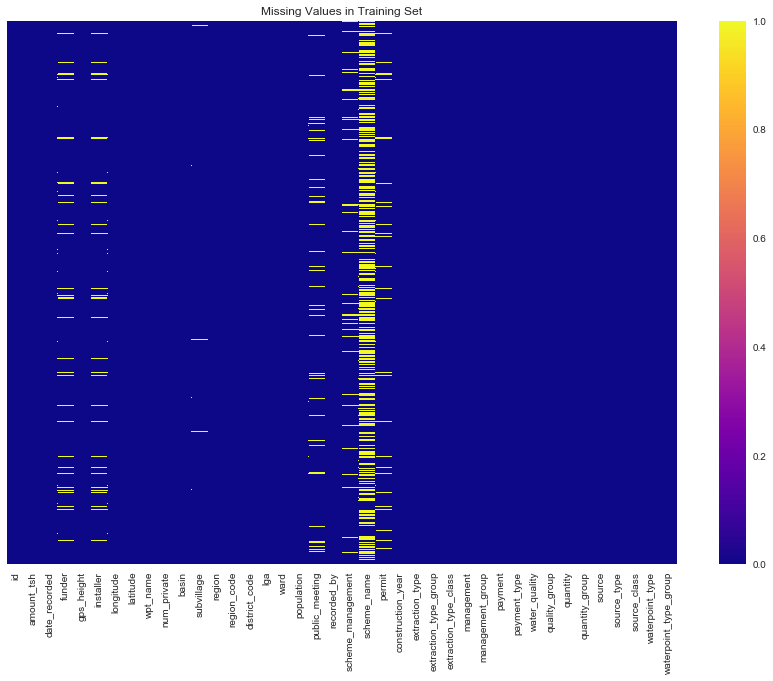

In [18]:
missing_value_plot(train)

### Looking for relationships

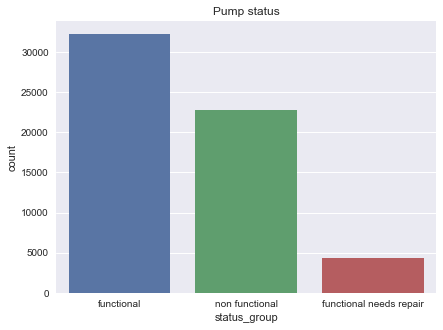

In [91]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(train_labels.status_group)
plt.title('Pump status');

#### Source variables

It appears that ``source_type`` and ``source`` contain very similar information. May not be worth retaining all of these variables.

In [26]:
count_pct(train, ['source', 'source_type', 'source_class'])

,source,source_type,source_class,count,pct
8,spring,spring,groundwater,17021,0.286549
7,shallow well,shallow well,groundwater,16824,0.283232
3,machine dbh,borehole,groundwater,11075,0.186448
6,river,river/lake,surface,9612,0.161818
5,rainwater harvesting,rainwater harvesting,surface,2295,0.038636
1,hand dtw,borehole,groundwater,874,0.014714
2,lake,river/lake,surface,765,0.012879
0,dam,dam,surface,656,0.011044
4,other,other,unknown,212,0.003569
9,unknown,other,unknown,66,0.001111


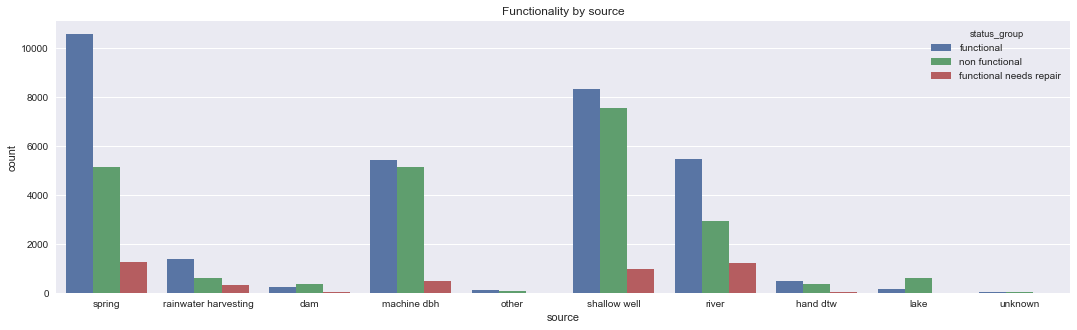

In [68]:
plt.figure(figsize=(40,5))
plt.subplot(1,2,2)
sns.countplot(x = "source", hue = "status_group", data = full_train)
plt.title('Functionality by source');

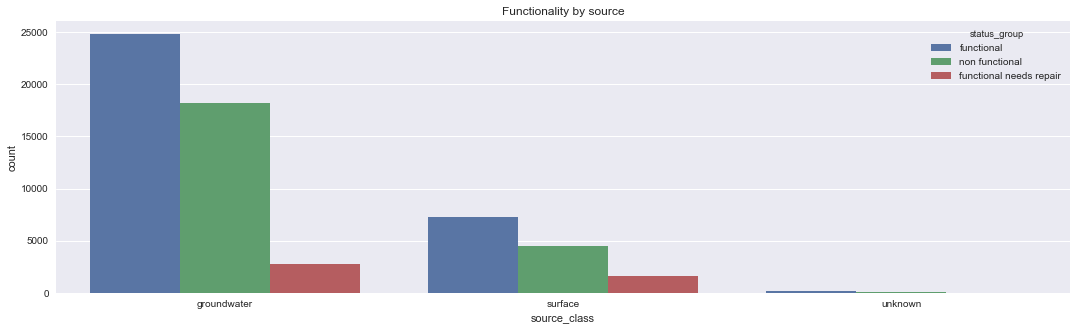

In [70]:
plt.figure(figsize=(40,5))
plt.subplot(1,2,2)
sns.countplot(x = "source_class", hue = "status_group", data = full_train)
plt.title('Functionality by source class');

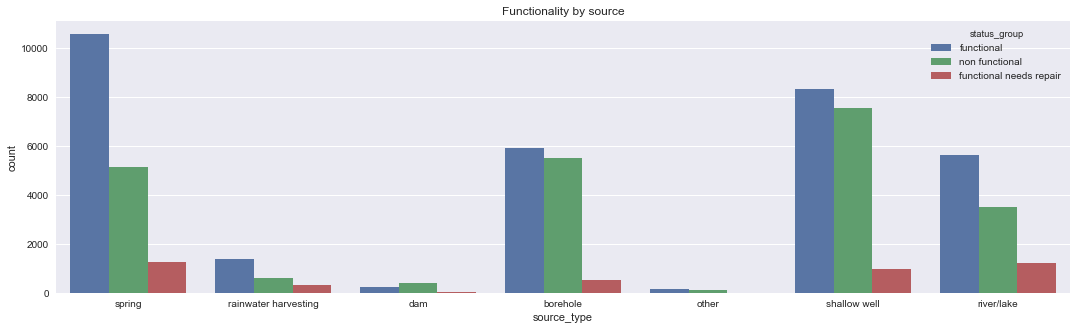

In [71]:
plt.figure(figsize=(40,5))
plt.subplot(1,2,2)
sns.countplot(x = "source_type", hue = "status_group", data = full_train)
plt.title('Functionality by source type');

source_class appears to be the least informative of these variables. Likely to exclude.

#### Waterpoint Type Variables

In [67]:
count_pct(train, 'waterpoint_type')

,waterpoint_type,count,pct
1,communal standpipe,28522,0.480168
4,hand pump,17488,0.294411
6,other,6380,0.107407
2,communal standpipe multiple,6103,0.102744
5,improved spring,784,0.013199
0,cattle trough,116,0.001953
3,dam,7,0.000118


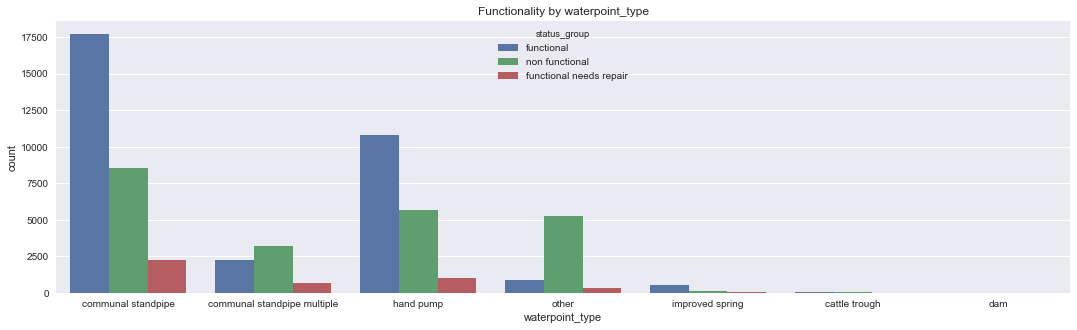

In [66]:
plt.figure(figsize=(40,5))
plt.subplot(1,2,2)
sns.countplot(x = "waterpoint_type", hue = "status_group", data = full_train)
plt.title('Functionality by waterpoint_type');

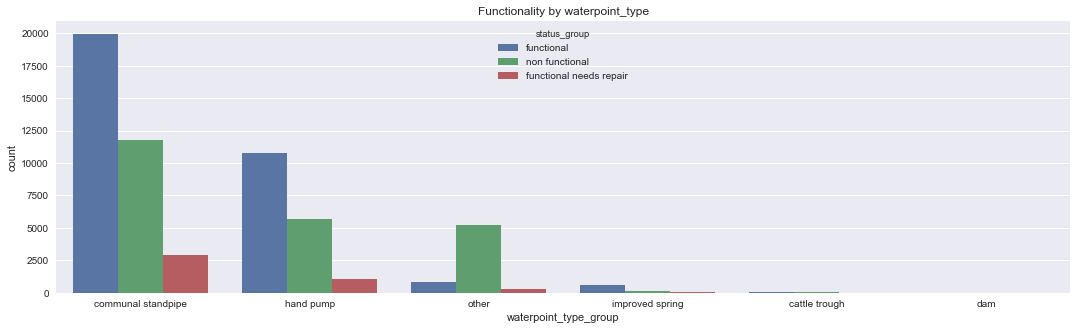

In [65]:
plt.figure(figsize=(40,5))
plt.subplot(1,2,2)
sns.countplot(x = "waterpoint_type_group", hue = "status_group", data = full_train)
plt.title('Functionality by waterpoint_type');

waterpoint_type appears to have some relationship to functionality--likely worth including in a model

#### Exploring year
Logically it would make sense that older pumps would be more likely to be non-functional. What is the distribution of values for this variable? Is there an apparent relationship between construction year and functionality?

In [28]:
count_pct(train, 'construction_year').head()

,construction_year,count,pct
0,0,20709,0.348636
51,2010,2645,0.044529
49,2008,2613,0.043990
50,2009,2533,0.042643
41,2000,2091,0.035202


Clearly there are missing values to be dealt with here. Presumably we can eliminate the possibility that any of the pumps are on the order of 2,000 years old.

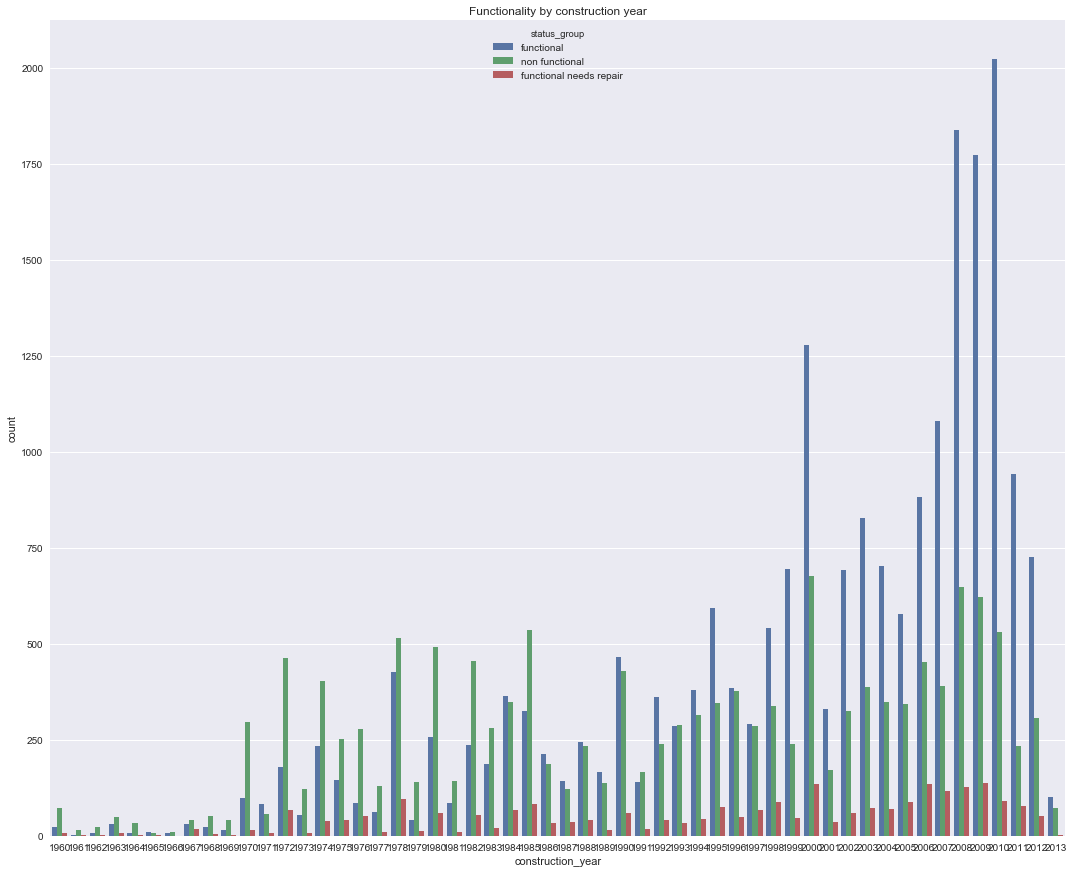

In [35]:
plt.figure(figsize=(40,15))
plt.subplot(1,2,2)
sns.countplot(x = "construction_year", hue = "status_group", data = full_train[full_train['construction_year'] > 0])
plt.title('Functionality by construction year');

When missing values are excluded, there is a clear relationship between functionality and construction year, which stands to reason. Missing values for year will need to be imputed before modeling.

#### Exploring TSH
There are lots of 0s in amount_tsh (total static head, "The vertical height of a stationary column of liquid produced by a pump, measured from the suction level").

In [25]:
count_pct(train, 'amount_tsh')

,amount_tsh,count,pct
0,0.0,41639,0.700993
34,500.0,3102,0.052222
19,50.0,2472,0.041616
43,1000.0,1488,0.025051
12,20.0,1463,0.024630
...,...,...,...
14,26.0,1,0.000017
60,5400.0,1,0.000017
10,12.0,1,0.000017
63,6300.0,1,0.000017


Are these 0s valid or invalid? Given the construction_year variable, it might be safe to assume that these values should be conisdered missing. The first thing to check is the functionality distribution where amount_tsh == 0. If all are non-functional, then perhaps they are true 0s.

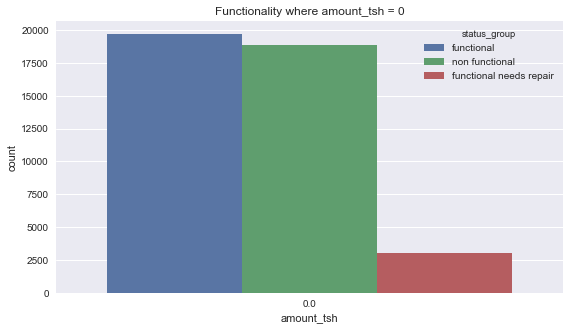

In [31]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
sns.countplot(x = "amount_tsh", hue = "status_group", data = full_train[full_train['amount_tsh'] == 0])
plt.title('Functionality where amount_tsh = 0');

A slightly higher proportion of wells with amount_tsh == 0 are non-functional compared to the overall distribution, but it's slight. Is there a visible pattern in the wells with a recorded value for amount_tsh?

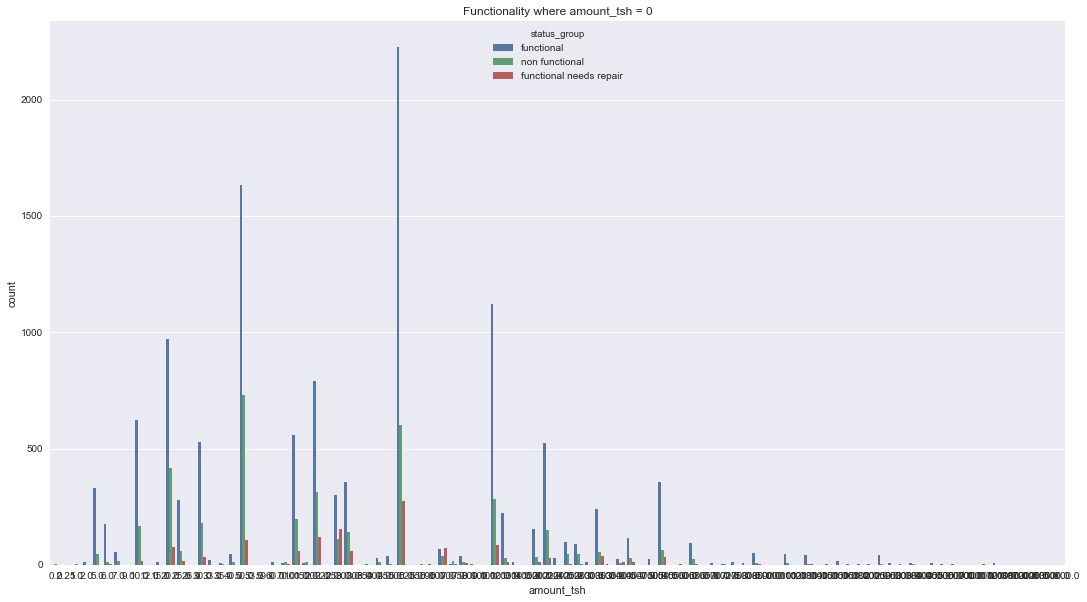

In [34]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,2)
sns.countplot(x = "amount_tsh", hue = "status_group", data = full_train[full_train['amount_tsh'] > 0])
plt.title('Functionality where amount_tsh = 0');

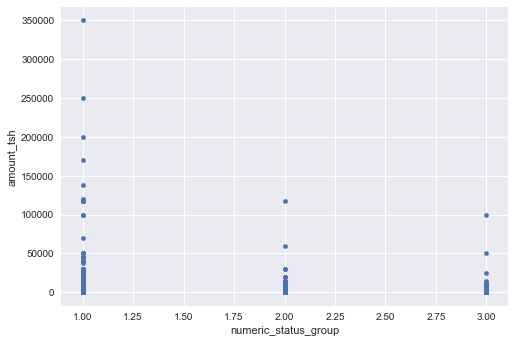

In [21]:
full_train[full_train['amount_tsh'] > 0].plot.scatter('numeric_status_group', 'amount_tsh')

There does not seem to be a clear pattern. The spread of values is very large, though. What does this spread look like?

In [46]:
five_number_summary(full_train[full_train['amount_tsh'] > 0]['amount_tsh'])

Min: 0.200
Q1: 50.000
Median: 250.000
Q3: 1000.000
Max: 350000.000


The max value reveals at least one very high outlier. The competition description does not give the units, but the standard (from some internet research) seems to be either feet or meters. If meters, the max value is almost 40 times the height of Mt Everest. Is there a visible pattern when the top quartile is excluded?

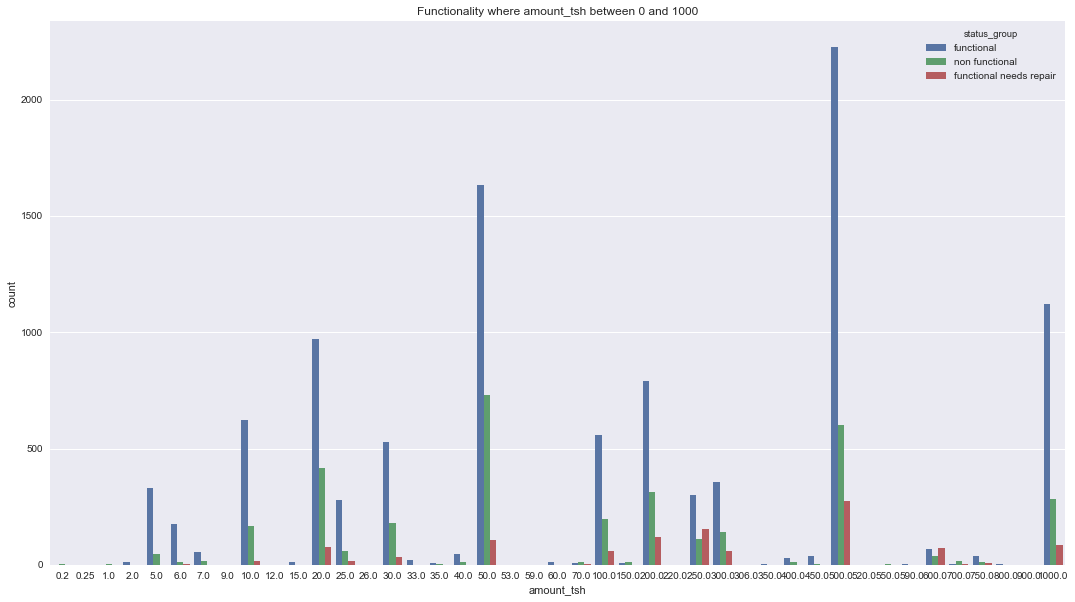

In [72]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,2)
sns.countplot(x = "amount_tsh", hue = "status_group", data = full_train.loc[(full_train['amount_tsh'] > 0) & (full_train['amount_tsh'] <= 1000)])
plt.title('Functionality where amount_tsh between 0 and 1000');

Contrary to my initial intuition, it appears that there is not a strong relationship between amount_tsh and functionality. Given the large amount of missing data and the lack of a strong relationship, I am unlikely to include this in the model.

### Quantity
It seems likely that the amount of available water will play a role in the well's functionality

In [78]:
count_pct(train, ['quantity', 'quantity_group'])

,quantity,quantity_group,count,pct
1,enough,enough,33186,0.558687
2,insufficient,insufficient,15129,0.254697
0,dry,dry,6246,0.105152
3,seasonal,seasonal,4050,0.068182
4,unknown,unknown,789,0.013283


It seems that ``quantity`` and ``quantity_group`` are functionally identical. Only need to include one.

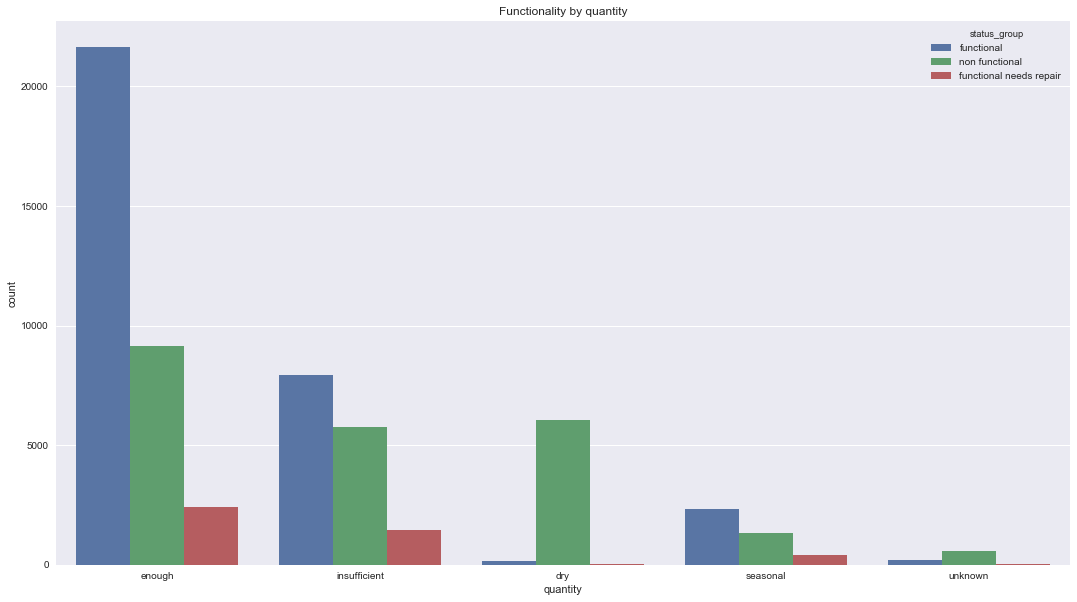

In [81]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,2)
sns.countplot(x = "quantity", hue = "status_group", data = full_train)
plt.title('Functionality by quantity');

A well being dry is a very strong predictor of the well being non-functional (how one could ever have a functional well with no water in it is beyond me, but I digress).

#### GPS height

Another variable that seems to have 0s in place of missing data

In [84]:
count_pct(train, 'gps_height').head(20)

,gps_height,count,pct
59,0,20438,0.344074
44,-15,60,0.001010
46,-13,55,0.000926
43,-16,55,0.000926
1348,1290,52,0.000875
39,-20,52,0.000875
362,303,51,0.000859
45,-14,51,0.000859
41,-18,49,0.000825
40,-19,47,0.000791


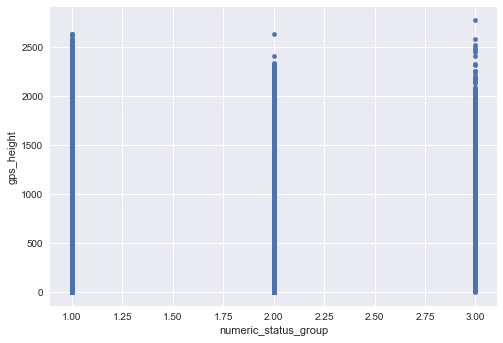

In [23]:
full_train[full_train['gps_height'] > 0].plot.scatter('numeric_status_group', 'gps_height')

#### Quality variables

In [85]:
count_pct(train, ['water_quality', 'quality_group'])

,water_quality,quality_group,count,pct
6,soft,good,50818,0.855522
4,salty,salty,4856,0.081751
7,unknown,unknown,1876,0.031582
3,milky,milky,804,0.013535
0,coloured,colored,490,0.008249
5,salty abandoned,salty,339,0.005707
1,fluoride,fluoride,200,0.003367
2,fluoride abandoned,fluoride,17,0.000286


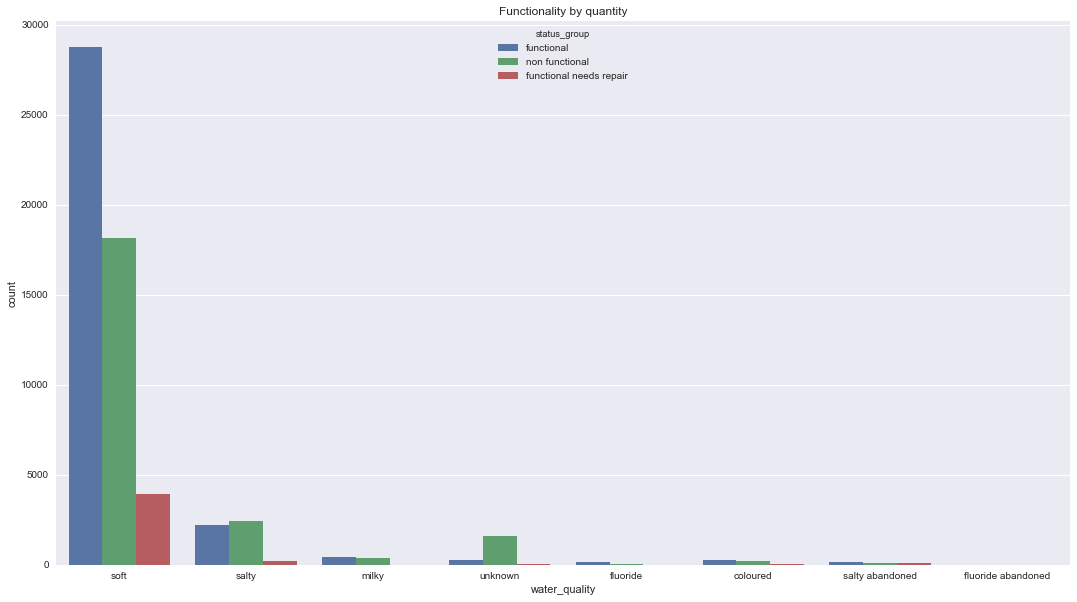

In [87]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,2)
sns.countplot(x = "water_quality", hue = "status_group", data = full_train)
plt.title('Functionality by water quality');

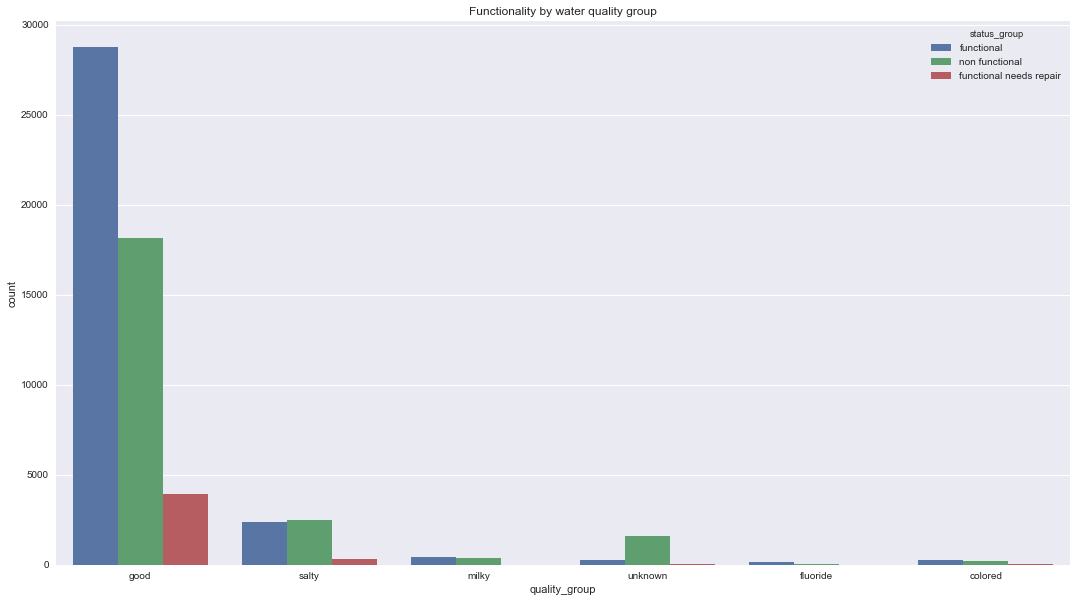

In [90]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,2)
sns.countplot(x = "quality_group", hue = "status_group", data = full_train)
plt.title('Functionality by water quality group');

Salty and unknown quality wells are more likely to be non-functional. Definitely worth including, possibly as a binary good/not good.

#### Funder

Funder presents something of a challenge due to the large number of levels (almost 2,000). Given my current plan is to one-hot encode the data, many of these may end up being functionally zero variance features. Is there something interesting going on in the most common entrants?

In [10]:
len(train.funder.unique())

1898

In [40]:
count_pct(train, 'funder').head(25)

,funder,count,pct
456,government of tanzania,9084,0.162898
261,danida,3114,0.055841
513,hesawa,2202,0.039487
1416,rwssp,1374,0.024639
1865,world bank,1349,0.024191
727,kkkt,1287,0.023079
1867,world vision,1246,0.022344
1741,unicef,1057,0.018955
1633,tasaf,877,0.015727
302,district council,843,0.015117


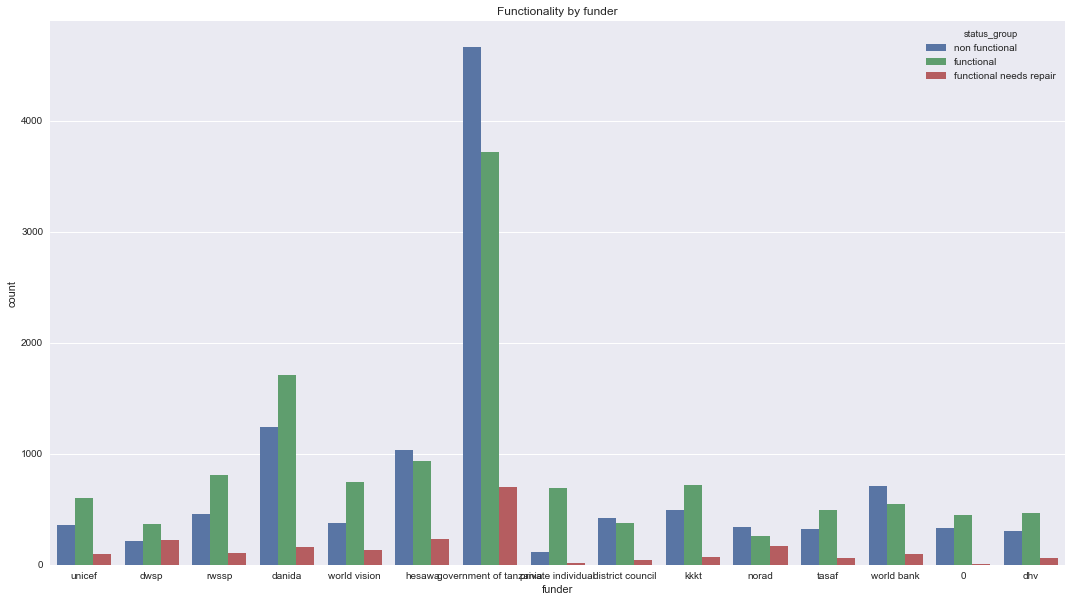

In [30]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,2)
sns.countplot(x = "funder", hue = "status_group", data = full_train[full_train['funder'].isin(count_pct(train, 'funder').head(15)['funder'].tolist())])
plt.title('Functionality by funder');

It seems like there is. Pumps funded by the Tanzanian government seem to work more often than not. Pumps funded by private individuals seem to hardly work at all. 0s as missing values rear their ugly head again. What does everything else look like? That is, would it be useful to look at these versus other? Or possibly Tanzanian government funded vs other?

In [28]:
full_train = full_train.assign(
    govt_funded = full_train['funder'].apply(lambda funder: 1 if funder == 'government of tanzania' else 0)
)

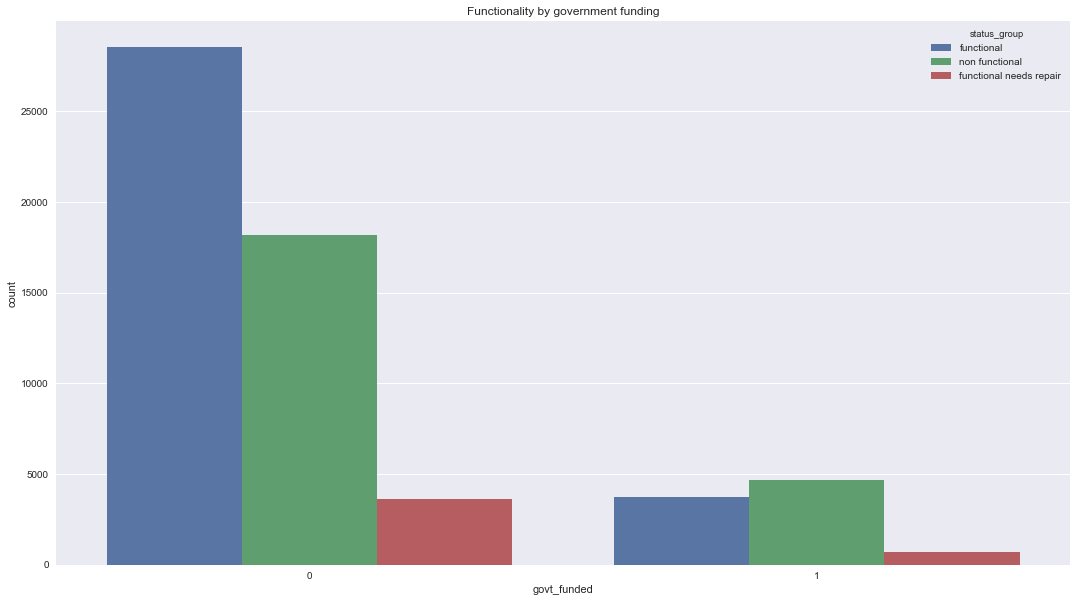

In [29]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,2)
sns.countplot(x = "govt_funded", hue = "status_group", data = full_train)
plt.title('Functionality by government funding');

In [25]:
top_funders = count_pct(train, 'funder').funder.tolist()[1:15]

mid_bucket_funder = count_pct(train, 'funder').funder.tolist()[16:1000]

full_train = full_train.assign(
    funder_buckets = full_train['funder'].apply(lambda funder: (1 if funder == 'government of tanzania' 
                                                                else 2 if funder in top_funders 
                                                                else 3 if funder in mid_bucket_funder 
                                                                else 4)
))

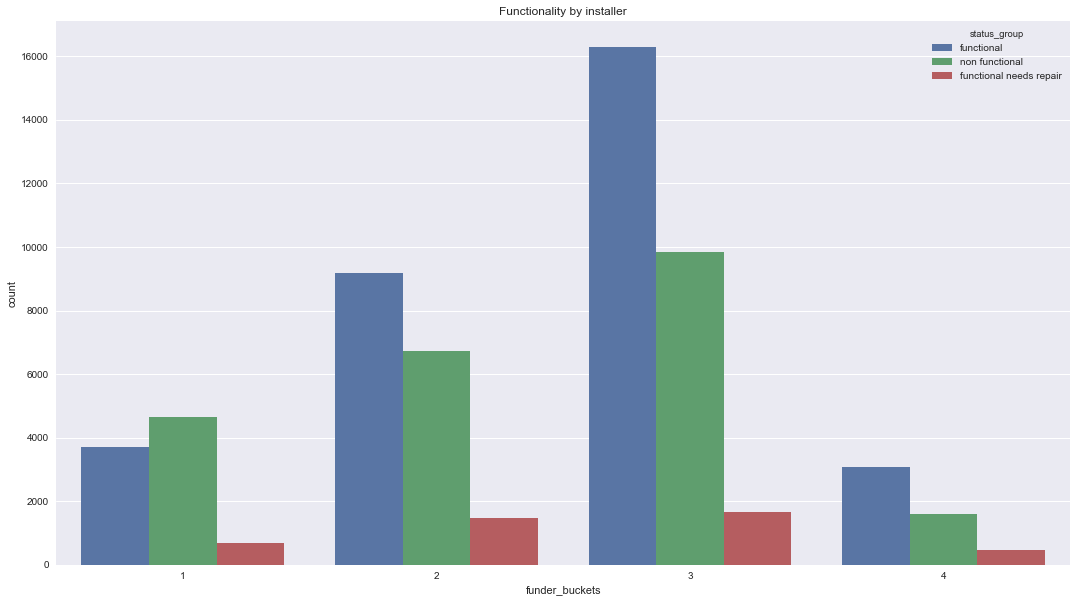

In [26]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,2)
sns.countplot(x = "funder_buckets", hue = "status_group", data = full_train)
plt.title('Functionality by installer');

In [99]:
count_pct(full_train[full_train['govt_funded'] != 1], 'funder')

,funder,count,pct
261,danida,3114,0.066708
512,hesawa,2202,0.047171
1415,rwssp,1374,0.029434
1864,world bank,1349,0.028898
726,kkkt,1287,0.027570
...,...,...,...
886,malola,1,0.000021
885,maliasili,1,0.000021
884,males,1,0.000021
882,makusa,1,0.000021


#### num_private

This variable has no description on the competition website and is very low variance (99% 0s, which may well mean 99% missing). Likely to exclude.

In [56]:
count_pct(train, 'num_private')

,num_private,count,pct
0,0,58643,0.987256
6,6,81,0.001364
1,1,73,0.001229
8,8,46,0.000774
5,5,46,0.000774
...,...,...,...
37,60,1,0.000017
24,30,1,0.000017
35,55,1,0.000017
27,35,1,0.000017


#### Installer

Installer presents a similar challenge to funder. Is it possible that a similar reduction will provide useful information when one-hot encoded?

In [71]:
len(train.installer.unique())

1936

In [59]:
count_pct(train, 'installer').head(15)

,installer,count,pct
385,dwe,17405,0.312225
511,government,1891,0.033922
583,hesawa,1395,0.025025
1446,rwe,1206,0.021634
261,commu,1065,0.019105
311,danida,1050,0.018836
360,district council,961,0.017239
800,kkkt,910,0.016324
1,0,777,0.013938
206,central government,763,0.013687


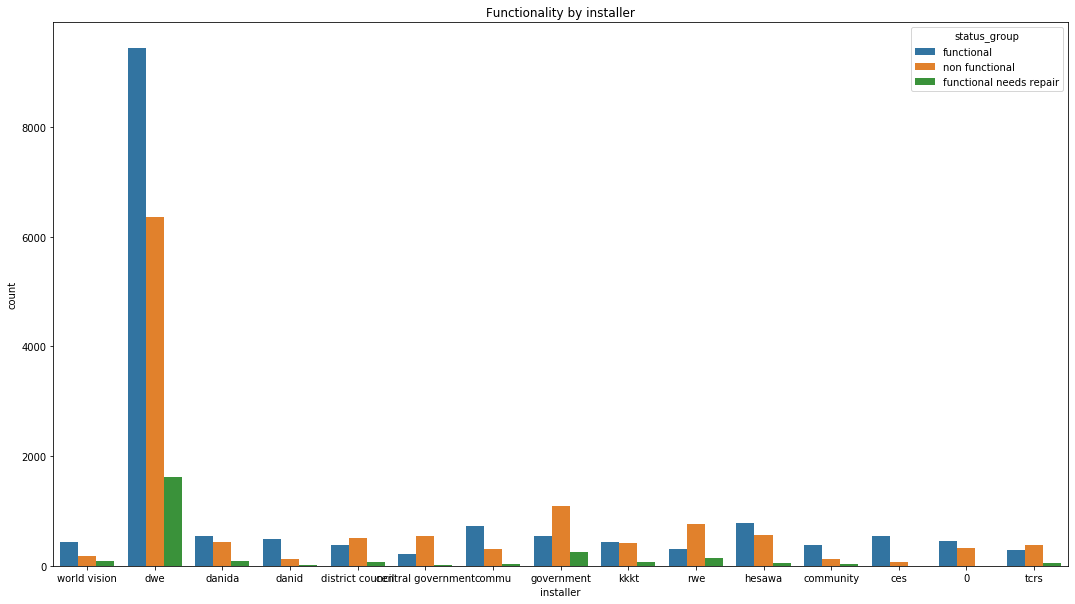

In [66]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,2)
sns.countplot(x = "installer", hue = "status_group", data = full_train[full_train['installer'].isin(count_pct(full_train, 'installer').head(15)['installer'].tolist())])
plt.title('Functionality by installer');

In [68]:
full_train = full_train.assign(
    dwe_installed = full_train['installer'].apply(lambda installer: 1 if installer == 'dwe' else 0)
)

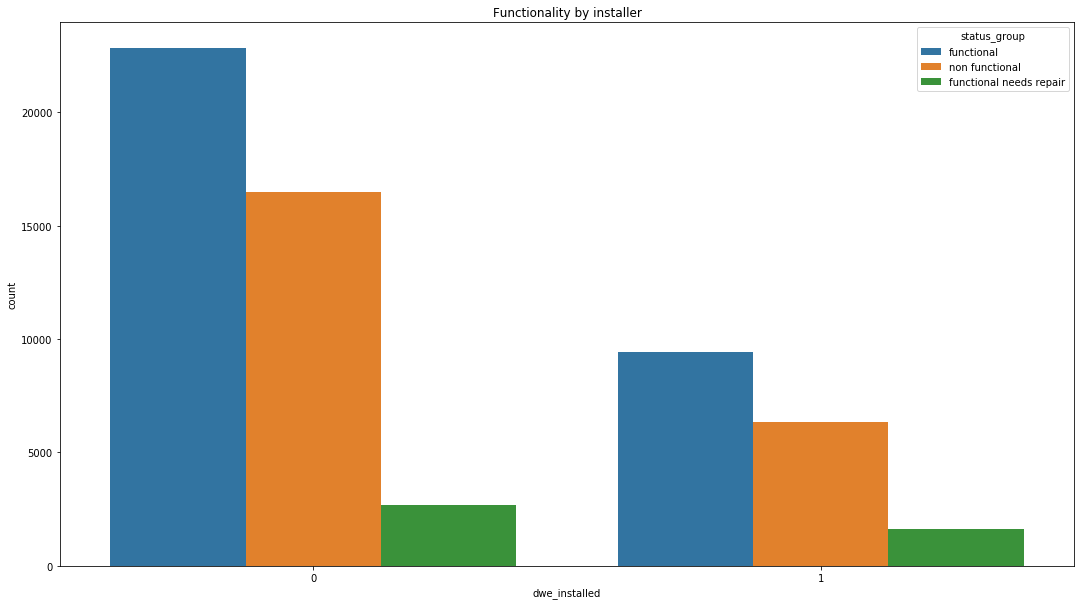

In [72]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,2)
sns.countplot(x = "dwe_installed", hue = "status_group", data = full_train)
plt.title('Functionality by installer');

In [90]:
top_installers = count_pct(train, 'installer').installer.tolist()[1:15]

mid_bucket = count_pct(train, 'installer').installer.tolist()[16:1000]

full_train = full_train.assign(
    install_buckets = full_train['installer'].apply(lambda installer: (1 if installer == 'dwe' 
                                                                       else 2 if installer in top_installers 
                                                                       else 3 if installer in mid_bucket 
                                                                       else 4)
))

In [88]:
count_pct(full_train, 'install_buckets')

,install_buckets,count,pct
2,3,23681,0.398670
0,1,17405,0.293013
1,2,13213,0.222441
3,4,5101,0.085875


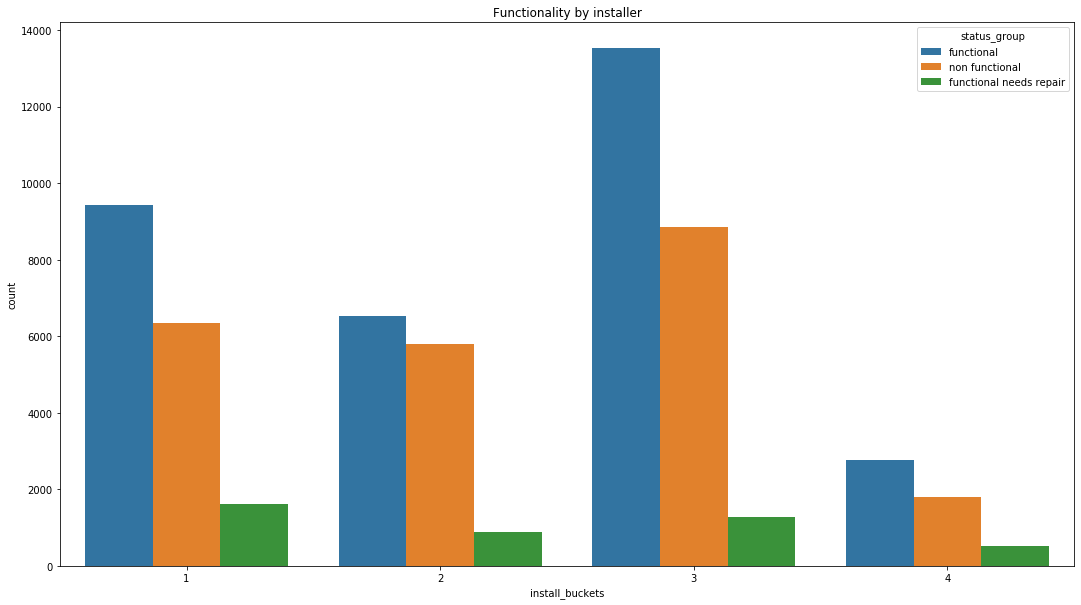

In [89]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,2)
sns.countplot(x = "install_buckets", hue = "status_group", data = full_train)
plt.title('Functionality by installer');

Given that the bucketization seems to obscure meaningful variation, will try label encoding categorical vars before going to one-hot encoding.

#### Payment type

Given that we exist in a capitalist system, I would expect that how or if the pumps are paid for will play a role.

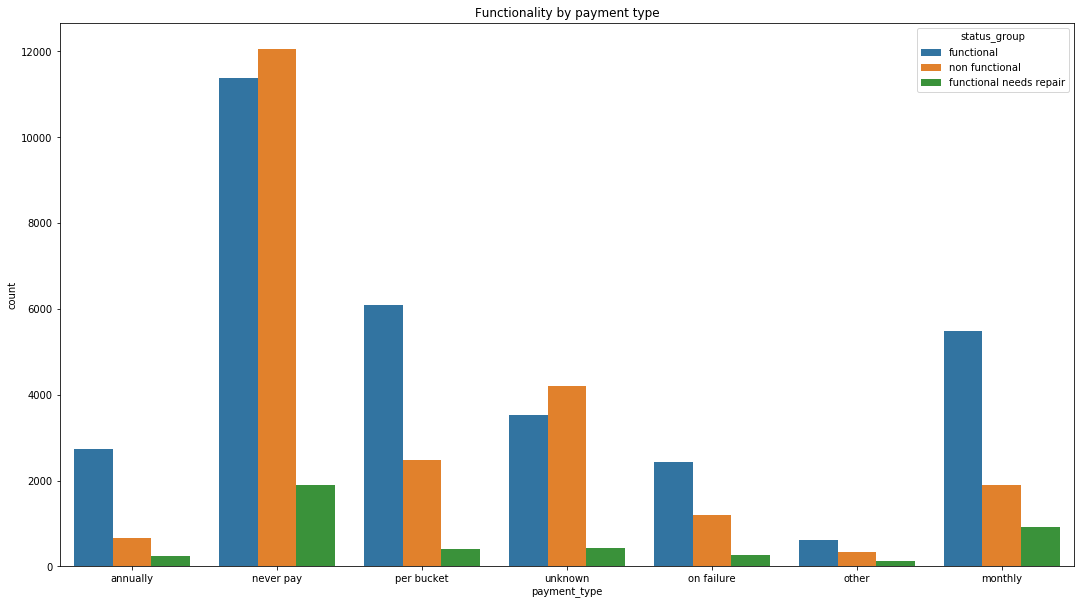

In [101]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,2)
sns.countplot(x = "payment_type", hue = "status_group", data = full_train)
plt.title('Functionality by payment type');

Perhaps unsurprisingly, when the wells are not paid for, they are much more likely to be non-functional.

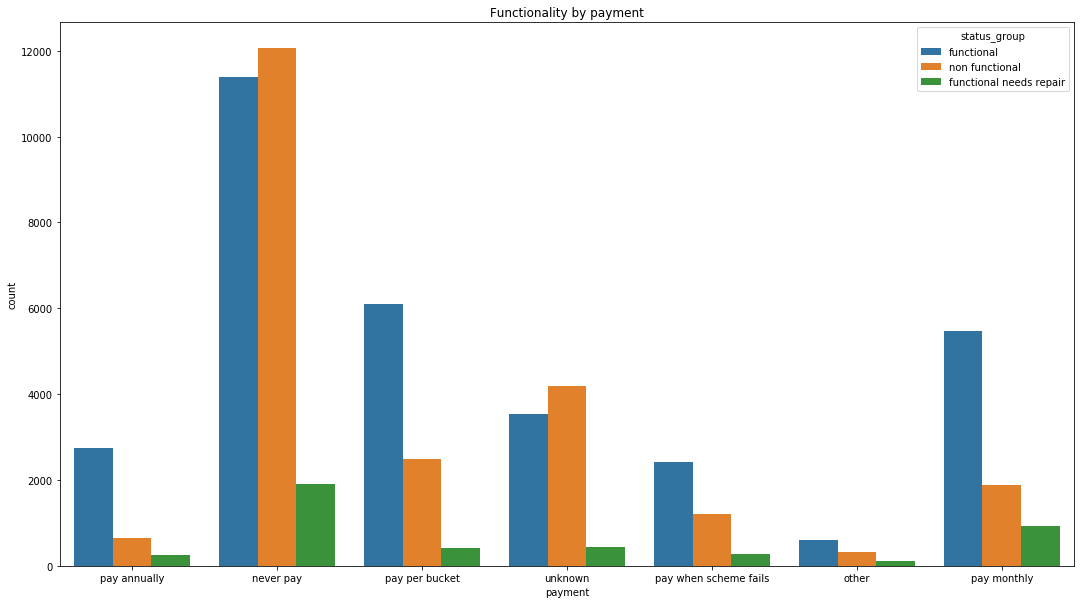

In [121]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,2)
sns.countplot(x = "payment", hue = "status_group", data = full_train)
plt.title('Functionality by payment');

These variables are redundant--choose one

#### Region variables

How does the region of Tanzania affect the functionality of the well?

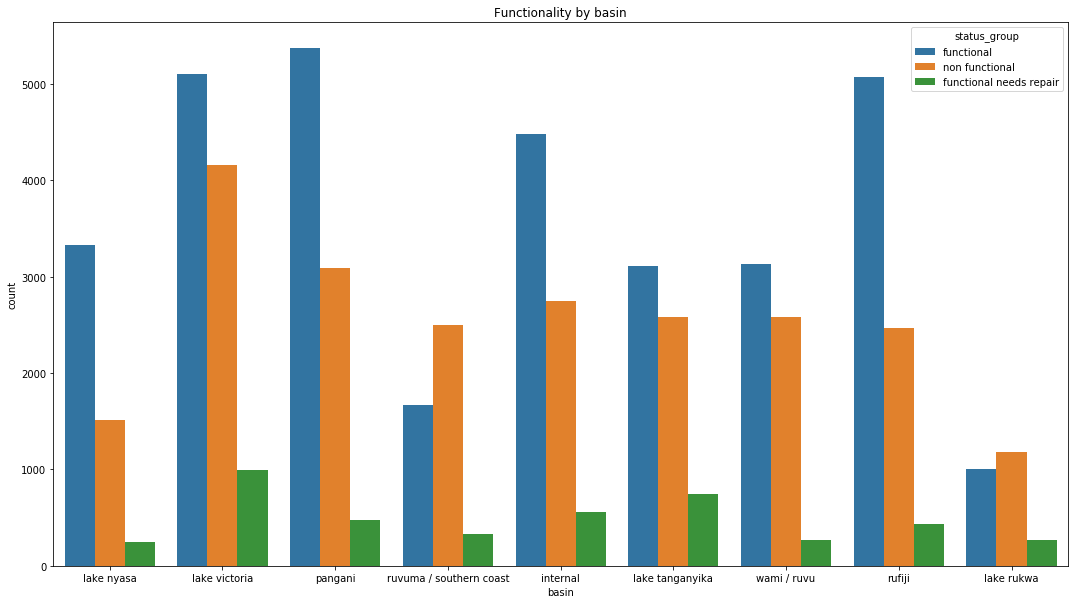

In [104]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,2)
sns.countplot(x = "basin", hue = "status_group", data = full_train)
plt.title('Functionality by basin');

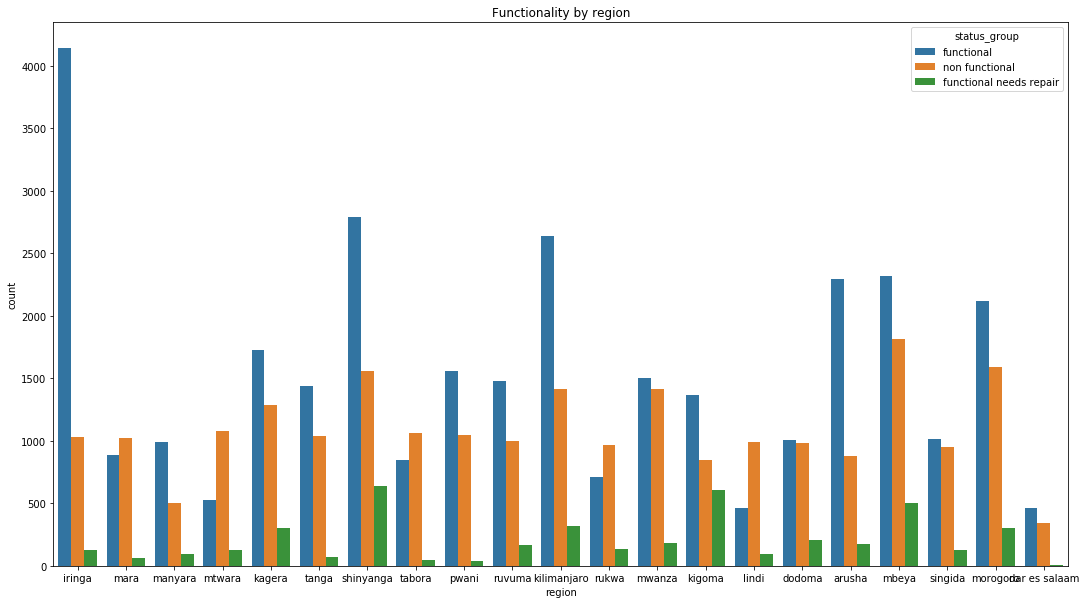

In [124]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,2)
sns.countplot(x = "region", hue = "status_group", data = full_train)
plt.title('Functionality by region');

#### Extraction variables

Does extraction type have an apparent relationship with functionality?

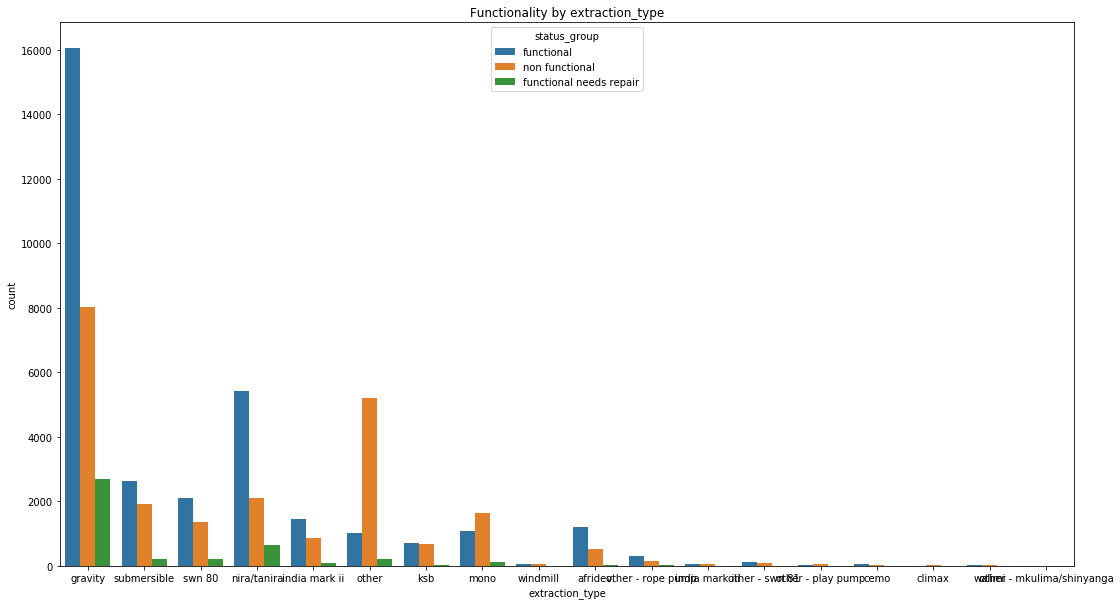

In [110]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,2)
sns.countplot(x = "extraction_type", hue = "status_group", data = full_train)
plt.title('Functionality by extraction_type');

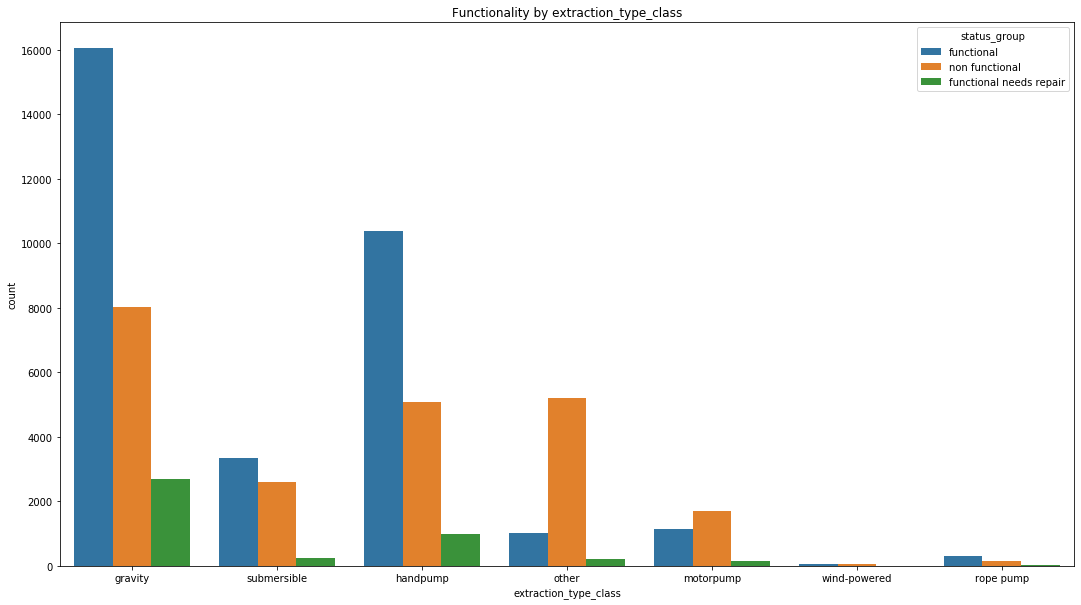

In [16]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,2)
sns.countplot(x = "extraction_type_class", hue = "status_group", data = full_train)
plt.title('Functionality by extraction_type_class');

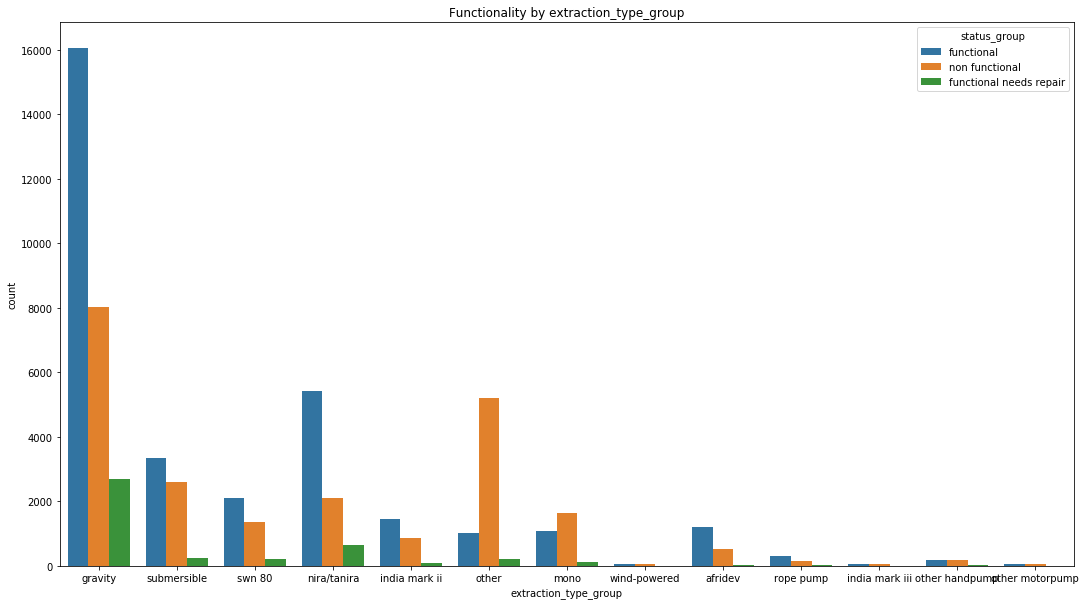

In [120]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,2)
sns.countplot(x = "extraction_type_group", hue = "status_group", data = full_train)
plt.title('Functionality by extraction_type_group');

Code rare classes of extraction_type_group or extraction_type to other and use

#### Management variables



In [111]:
count_pct(train, 'scheme_management')

,scheme_management,count,pct
7,vwc,36793,0.662662
11,wug,5206,0.093763
8,water authority,3153,0.056787
10,wua,2883,0.051924
9,water board,2748,0.049493
3,parastatal,1680,0.030258
4,private operator,1063,0.019145
0,company,1061,0.019109
2,other,766,0.013796
5,swc,97,0.001747


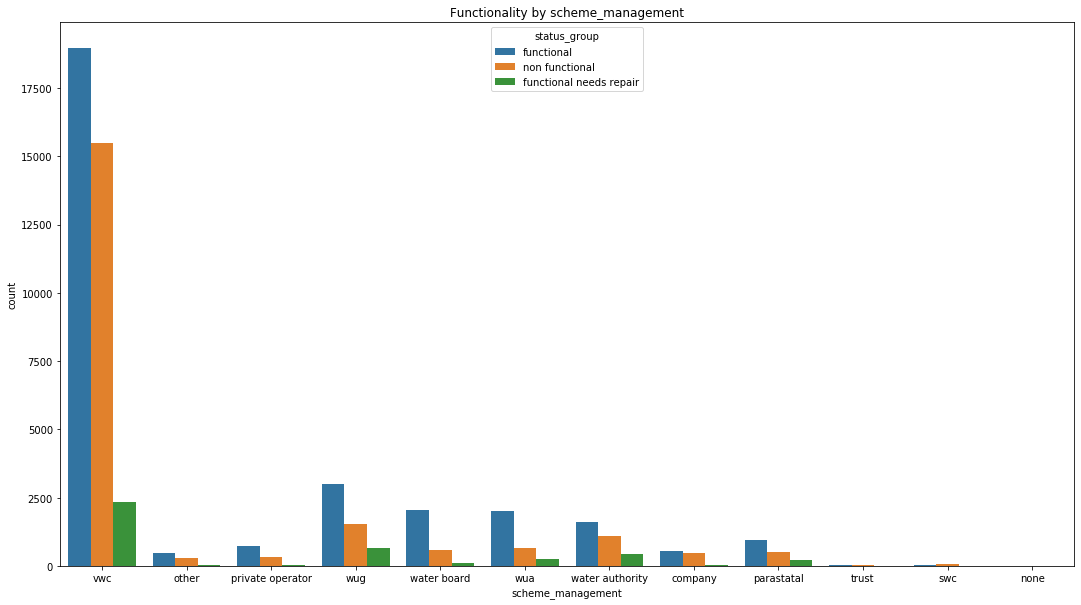

In [113]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,2)
sns.countplot(x = "scheme_management", hue = "status_group", data = full_train)
plt.title('Functionality by scheme_management');

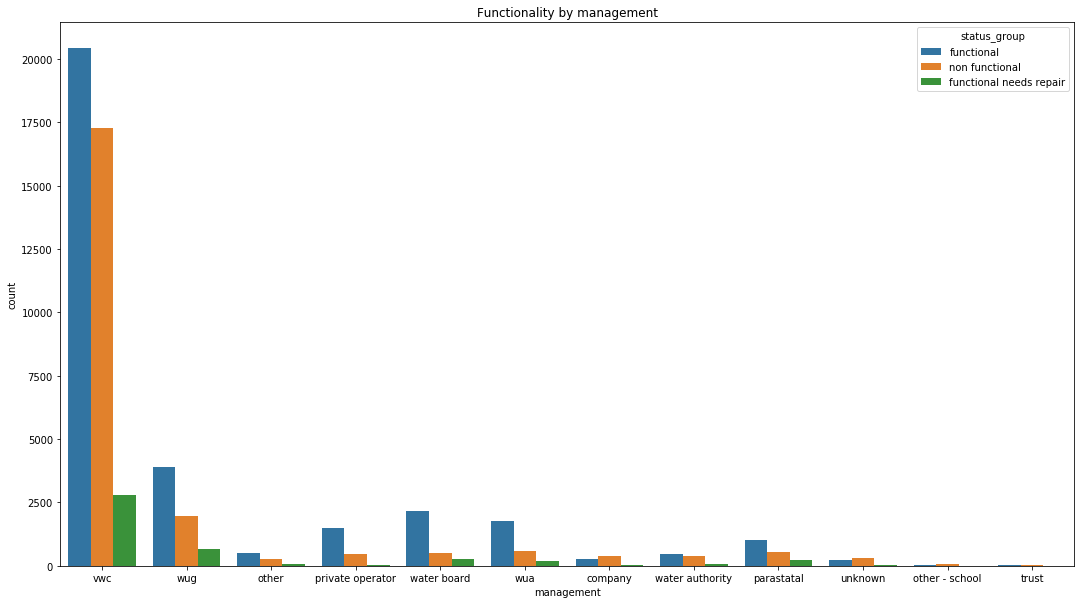

In [15]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,2)
sns.countplot(x = "management", hue = "status_group", data = full_train)
plt.title('Functionality by management');

In [117]:
count_pct(train, 'management_group')

,management_group,count,pct
4,user-group,52490,0.883670
0,commercial,3638,0.061246
2,parastatal,1768,0.029764
1,other,943,0.015875
3,unknown,561,0.009444


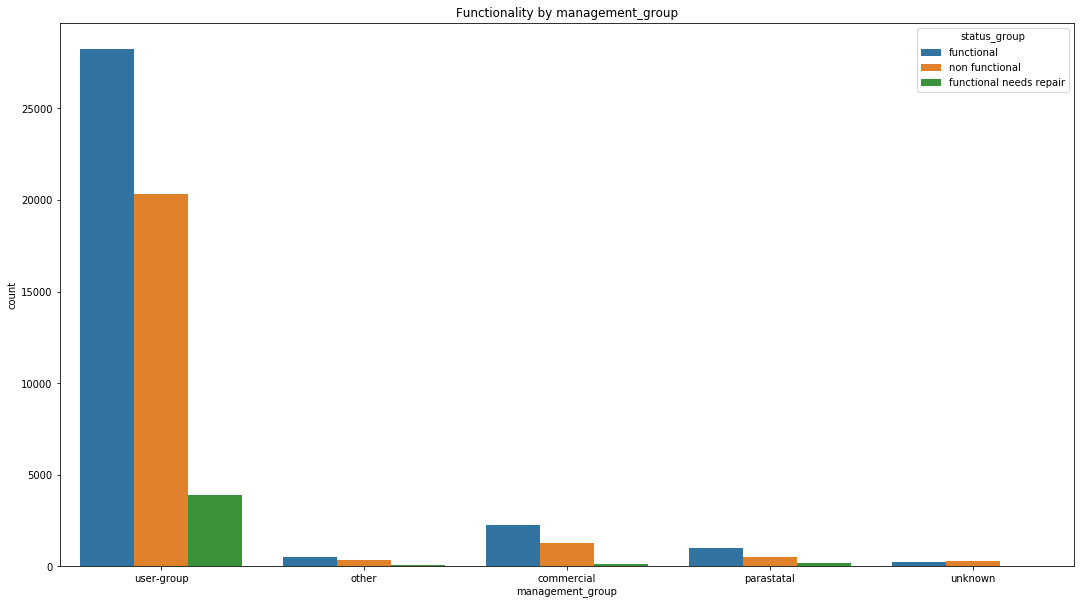

In [122]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,2)
sns.countplot(x = "management_group", hue = "status_group", data = full_train)
plt.title('Functionality by management_group');

Use scheme management, recode rare categories into other

#### Permit

There does not appear to be a strong relationship here, but low cost to include

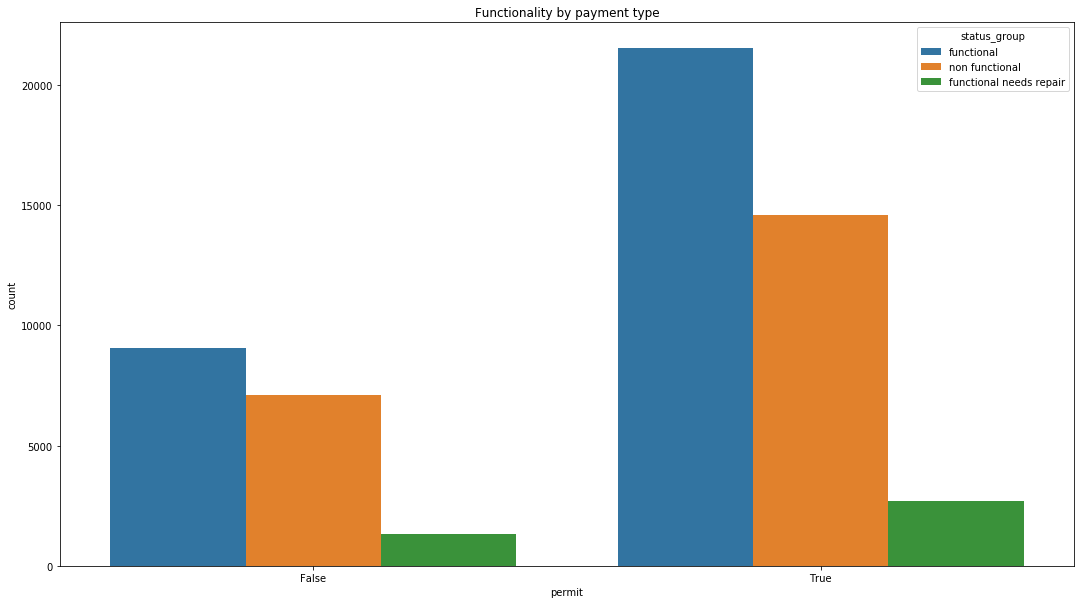

In [4]:
plt.figure(figsize=(40,10))
plt.subplot(1,2,2)
sns.countplot(x = "permit", hue = "status_group", data = full_train)
plt.title('Functionality by payment type');

#### Population

In [6]:
count_pct(train, 'population')

,population,count,pct
0,0,21381,0.359949
1,1,7025,0.118266
197,200,1940,0.032660
149,150,1892,0.031852
247,250,1681,0.028300
...,...,...,...
165,166,1,0.000017
726,895,1,0.000017
722,887,1,0.000017
721,886,1,0.000017


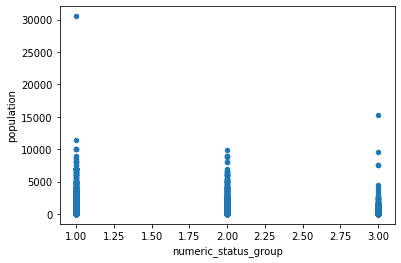

In [13]:
full_train.plot.scatter(x = 'numeric_status_group', y = 'population')